In [11]:
from __future__ import print_function, division

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [15]:
#!pip install opencv-python==3.4.2.16
#!pip install opencv-contrib-python==3.4.2.16

import os
import torch
import glob
import imageio as io
import numpy as np
#from shapely.geometry.point import Point
#from skimage.draw import circle_perimeter_aa,circle
import matplotlib.pyplot as plt
import cv2
import math
import pandas as pd
#from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import random

In [16]:
samplevone= '/content/drive/My Drive/video_samples/shaky_video1.mp4'
samplevtwo= '/content/drive/My Drive/video_samples/shaky_video2.mp4'
samplevthree= '/content/drive/My Drive/video_samples/shaky_video3.mp4'
samplevfive= '/content/drive/My Drive/video_samples/shaky_video5.mp4'
samplevsix= '/content/drive/My Drive/video_samples/shaky_video6.mp4'
samplevseven= '/content/drive/My Drive/video_samples/shaky_video7.mp4'
sampleveight= '/content/drive/My Drive/video_samples/shaky_video8.mp4'

# Load Video frames

In [17]:
def getVideoFrame(vpath):

  Framelist = []
  cap = cv2.VideoCapture(vpath)

  while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
      Framelist.append(frame)
    else: 
      break

  cap.release()
  cv2.destroyAllWindows()
  finalFramelist = np.array(Framelist)

  return finalFramelist 

# Convert frames to Video

In [18]:
def convertFramesToVideo(frames, fileName):
  height, width, layers = frames[0].shape
  size = (width,height)
  out = cv2.VideoWriter('/content/drive/My Drive/video_samples/output/' + fileName + '.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 30, size)
 
  for i in range(len(frames)):
      out.write(frames[i])
  out.release()

# Decrease Total Frames

In [19]:
def decreaseFrames(frames, factor):
  newFrames = []
  for i in range(math.floor(len(frames)/factor)):
    newFrames.append(frames[i*factor])
  finalnewFrames = np.array(newFrames)
  return finalnewFrames

# Using Laplacian to remove Blur frames

In [21]:
def getlapframes(originalFrames):
  resultFrames= []
  resultFrames.append(originalFrames[0])
    
  for i in range(0, len(originalFrames) - 1):
    if cv2.Laplacian(originalFrames[i + 1], cv2.CV_64F).var() > 20:
      resultFrames.append(originalFrames[i + 1])
    
  return resultFrames

# SIFT Feature Matching

In [22]:
def frames_sift(frame1, frame2):
  sift = cv2.xfeatures2d.SIFT_create()

  kp_1, des_1 = sift.detectAndCompute(frame1, None)
  kp_2, des_2 = sift.detectAndCompute(frame2, None)

  index_params = dict(algorithm = 0, trees = 5)
  search_params = dict(checks = 50)

  flann = cv2.FlannBasedMatcher( index_params, search_params)
  matches = flann.knnMatch(des_1,des_2,k=2)

  good = []
  for m,n in matches:
    if m.distance < 0.6*n.distance:
      good.append(m)


  dst_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ])
  src_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ])

  return src_pts, dst_pts

In [23]:
def getTransformedFrame(frame1, frame2):
  sift = cv2.xfeatures2d.SIFT_create()
  img1 = frame1.copy()
  img2 = frame2.copy()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  flann = cv2.FlannBasedMatcher( dict(algorithm = 0, trees = 5), dict(checks = 50))
  matches = flann.knnMatch(des_1,des_2,k=2)

  good = []

  for m,n in matches:
    if m.distance < 0.7*n.distance:
      good.append(m)

  if len(good) > 50:
      dst_pts = np.float32([ kp2[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      src_pts = np.float32([ kp1[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

      M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,7.0)

      h,w,c = img1.shape

      #pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      #print(pts.shape)
      #dst = cv2.perspectiveTransform(pts,M)
      img4 = cv2.warpPerspective(img2,M,(w,h))
      #print(img4.shape)
      newimg1 = cv2.drawKeypoints(img1,kp1,img1)
      newimg2 = cv2.drawKeypoints(img2,kp2,img2)
      fig, ax = plt.subplots(1, 3)
      ax[0].imshow(newimg1)
      ax[1].imshow(newimg2)
      ax[2].imshow(img4)
      plt.show()
      return img4

  else:
      return np.empty((0, 0))

In [24]:
def getStabilizedFrames(originalFrames):
  stabilizedFrames = [originalFrames[0]]
  for i in range(0, len(originalFrames) - 1):
    if cv2.Laplacian(originalFrames[i + 1], cv2.CV_64F).var() > 30:
      newFrame = getTransformedFrame(stabilizedFrames[-1], originalFrames[i + 1])
    if newFrame.size != 0:
      stabilizedFrames.append(newFrame) 
  return stabilizedFrames

# Network

@inproceedings{guo2019group,
  title={Group-wise Correlation Stereo Network},
  author={Guo, Xiaoyang and Yang, Kai and Yang, Wukui and Wang, Xiaogang and Li, Hongsheng},
  booktitle={Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition},
  pages={3273--3282},
  year={2019}
}

In [0]:
directory = "/content/drive/My Drive/gwcnet-g"

In [0]:
the_model = torch.load(directory + "/best.ckpt")

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable
from torch.autograd.function import Function
import torch.nn.functional as F
import numpy as np



def convbn(in_channels, out_channels, kernel_size, stride, pad, dilation):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                                   padding=dilation if dilation > 1 else pad, dilation=dilation, bias=False),
                         nn.BatchNorm2d(out_channels))


def convbn_3d(in_channels, out_channels, kernel_size, stride, pad):
    return nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                                   padding=pad, bias=False),
                         nn.BatchNorm3d(out_channels))


def disparity_regression(x, maxdisp):
    assert len(x.shape) == 4
    disp_values = torch.arange(0, maxdisp, dtype=x.dtype, device=x.device)
    disp_values = disp_values.view(1, maxdisp, 1, 1)
    return torch.sum(x * disp_values, 1, keepdim=False)


def build_concat_volume(refimg_fea, targetimg_fea, maxdisp):
    B, C, H, W = refimg_fea.shape
    volume = refimg_fea.new_zeros([B, 2 * C, maxdisp, H, W])
    for i in range(maxdisp):
        if i > 0:
            volume[:, :C, i, :, i:] = refimg_fea[:, :, :, i:]
            volume[:, C:, i, :, i:] = targetimg_fea[:, :, :, :-i]
        else:
            volume[:, :C, i, :, :] = refimg_fea
            volume[:, C:, i, :, :] = targetimg_fea
    volume = volume.contiguous()
    return volume


def groupwise_correlation(fea1, fea2, num_groups):
    B, C, H, W = fea1.shape
    assert C % num_groups == 0
    channels_per_group = C // num_groups
    cost = (fea1 * fea2).view([B, num_groups, channels_per_group, H, W]).mean(dim=2)
    assert cost.shape == (B, num_groups, H, W)
    return cost


def build_gwc_volume(refimg_fea, targetimg_fea, maxdisp, num_groups):
    B, C, H, W = refimg_fea.shape
    volume = refimg_fea.new_zeros([B, num_groups, maxdisp, H, W])
    for i in range(maxdisp):
        if i > 0:
            volume[:, :, i, :, i:] = groupwise_correlation(refimg_fea[:, :, :, i:], targetimg_fea[:, :, :, :-i],
                                                           num_groups)
        else:
            volume[:, :, i, :, :] = groupwise_correlation(refimg_fea, targetimg_fea, num_groups)
    volume = volume.contiguous()
    return volume


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride, downsample, pad, dilation):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Sequential(convbn(inplanes, planes, 3, stride, pad, dilation),
                                   nn.ReLU(inplace=True))

        self.conv2 = convbn(planes, planes, 3, 1, pad, dilation)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            x = self.downsample(x)

        out += x

        return out

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable
import torch.nn.functional as F
import math


class feature_extraction(nn.Module):
    def __init__(self, concat_feature=False, concat_feature_channel=12):
        super(feature_extraction, self).__init__()
        self.concat_feature = concat_feature

        self.inplanes = 32
        self.firstconv = nn.Sequential(convbn(3, 32, 3, 2, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True),
                                       convbn(32, 32, 3, 1, 1, 1),
                                       nn.ReLU(inplace=True))

        self.layer1 = self._make_layer(BasicBlock, 32, 3, 1, 1, 1)
        self.layer2 = self._make_layer(BasicBlock, 64, 16, 2, 1, 1)
        self.layer3 = self._make_layer(BasicBlock, 128, 3, 1, 1, 1)
        self.layer4 = self._make_layer(BasicBlock, 128, 3, 1, 1, 2)

        if self.concat_feature:
            self.lastconv = nn.Sequential(convbn(320, 128, 3, 1, 1, 1),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(128, concat_feature_channel, kernel_size=1, padding=0, stride=1,
                                                    bias=False))

    def _make_layer(self, block, planes, blocks, stride, pad, dilation):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion), )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, pad, dilation))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, 1, None, pad, dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.firstconv(x)
        x = self.layer1(x)
        l2 = self.layer2(x)
        l3 = self.layer3(l2)
        l4 = self.layer4(l3)

        gwc_feature = torch.cat((l2, l3, l4), dim=1)

        if not self.concat_feature:
            return {"gwc_feature": gwc_feature}
        else:
            concat_feature = self.lastconv(gwc_feature)
            return {"gwc_feature": gwc_feature, "concat_feature": concat_feature}


class hourglass(nn.Module):
    def __init__(self, in_channels):
        super(hourglass, self).__init__()

        self.conv1 = nn.Sequential(convbn_3d(in_channels, in_channels * 2, 3, 2, 1),
                                   nn.ReLU(inplace=True))

        self.conv2 = nn.Sequential(convbn_3d(in_channels * 2, in_channels * 2, 3, 1, 1),
                                   nn.ReLU(inplace=True))

        self.conv3 = nn.Sequential(convbn_3d(in_channels * 2, in_channels * 4, 3, 2, 1),
                                   nn.ReLU(inplace=True))

        self.conv4 = nn.Sequential(convbn_3d(in_channels * 4, in_channels * 4, 3, 1, 1),
                                   nn.ReLU(inplace=True))

        self.conv5 = nn.Sequential(
            nn.ConvTranspose3d(in_channels * 4, in_channels * 2, 3, padding=1, output_padding=1, stride=2, bias=False),
            nn.BatchNorm3d(in_channels * 2))

        self.conv6 = nn.Sequential(
            nn.ConvTranspose3d(in_channels * 2, in_channels, 3, padding=1, output_padding=1, stride=2, bias=False),
            nn.BatchNorm3d(in_channels))

        self.redir1 = convbn_3d(in_channels, in_channels, kernel_size=1, stride=1, pad=0)
        self.redir2 = convbn_3d(in_channels * 2, in_channels * 2, kernel_size=1, stride=1, pad=0)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)

        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        conv5 = F.relu(self.conv5(conv4) + self.redir2(conv2), inplace=True)
        conv6 = F.relu(self.conv6(conv5) + self.redir1(x), inplace=True)

        return conv6


class GwcNet(nn.Module):
    def __init__(self, maxdisp, use_concat_volume=False):
        super(GwcNet, self).__init__()
        self.maxdisp = maxdisp
        self.use_concat_volume = use_concat_volume

        self.num_groups = 40

        if self.use_concat_volume:
            self.concat_channels = 12
            self.feature_extraction = feature_extraction(concat_feature=True,
                                                         concat_feature_channel=self.concat_channels)
        else:
            self.concat_channels = 0
            self.feature_extraction = feature_extraction(concat_feature=False)

        self.dres0 = nn.Sequential(convbn_3d(self.num_groups + self.concat_channels * 2, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True))

        self.dres1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1))

        self.dres2 = hourglass(32)

        self.dres3 = hourglass(32)

        self.dres4 = hourglass(32)

        self.classif0 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1, bias=False))

        self.classif1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1, bias=False))

        self.classif2 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1, bias=False))

        self.classif3 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1, bias=False))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, left, right):
        features_left = self.feature_extraction(left)
        features_right = self.feature_extraction(right)

        gwc_volume = build_gwc_volume(features_left["gwc_feature"], features_right["gwc_feature"], self.maxdisp // 4,
                                      self.num_groups)
        if self.use_concat_volume:
            concat_volume = build_concat_volume(features_left["concat_feature"], features_right["concat_feature"],
                                                self.maxdisp // 4)
            volume = torch.cat((gwc_volume, concat_volume), 1)
        else:
            volume = gwc_volume

        cost0 = self.dres0(volume)
        cost0 = self.dres1(cost0) + cost0

        out1 = self.dres2(cost0)
        out2 = self.dres3(out1)
        out3 = self.dres4(out2)

        if self.training:
            cost0 = self.classif0(cost0)
            cost1 = self.classif1(out1)
            cost2 = self.classif2(out2)
            cost3 = self.classif3(out3)

            cost0 = F.upsample(cost0, [self.maxdisp, left.size()[2], left.size()[3]], mode='trilinear')
            cost0 = torch.squeeze(cost0, 1)
            pred0 = F.softmax(cost0, dim=1)
            pred0 = disparity_regression(pred0, self.maxdisp)

            cost1 = F.upsample(cost1, [self.maxdisp, left.size()[2], left.size()[3]], mode='trilinear')
            cost1 = torch.squeeze(cost1, 1)
            pred1 = F.softmax(cost1, dim=1)
            pred1 = disparity_regression(pred1, self.maxdisp)

            cost2 = F.upsample(cost2, [self.maxdisp, left.size()[2], left.size()[3]], mode='trilinear')
            cost2 = torch.squeeze(cost2, 1)
            pred2 = F.softmax(cost2, dim=1)
            pred2 = disparity_regression(pred2, self.maxdisp)

            cost3 = F.upsample(cost3, [self.maxdisp, left.size()[2], left.size()[3]], mode='trilinear')
            cost3 = torch.squeeze(cost3, 1)
            pred3 = F.softmax(cost3, dim=1)
            pred3 = disparity_regression(pred3, self.maxdisp)
            return [pred0, pred1, pred2, pred3]

        else:
            cost3 = self.classif3(out3)
            cost3 = F.upsample(cost3, [self.maxdisp, left.size()[2], left.size()[3]], mode='trilinear')
            cost3 = torch.squeeze(cost3, 1)
            pred3 = F.softmax(cost3, dim=1)
            pred3 = disparity_regression(pred3, self.maxdisp)
            return [pred3]


def GwcNet_G(d):
    return GwcNet(d, use_concat_volume=False)


def GwcNet_GC(d):
    return GwcNet(d, use_concat_volume=True)

In [0]:
import os
import random
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import skimage
#from datasets.data_io import get_transform, read_all_lines

class CustomData(Dataset):
    def __init__(self, dataList):
        self.dataList = dataList

    def get_transform(self):
      mean = [0.485, 0.456, 0.406]
      std = [0.229, 0.224, 0.225]

      return transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=mean, std=std),
      ])

    def __len__(self):
        return len(self.dataList) - 1

    def __getitem__(self, index):
        left_img = self.dataList[index]
        right_img = self.dataList[index + 1]

        print(382, left_img.shape[1] - (left_img.shape[0] - 382))

        # left_img = cv2.resize(left_img, (382, left_img.shape[1] - (left_img.shape[0] - 382)))
        # # right_img = cv2.resize(right_img, (382,left_img.shape[1] - (left_img.shape[0] - 382)))
        left_img = skimage.transform.resize(left_img, (382, left_img.shape[1] - (left_img.shape[0] - 382)))
        right_img = skimage.transform.resize(right_img, (382,left_img.shape[1] - (left_img.shape[0] - 382)))

        #left_img = skimage.transform.resize(left_img, (382, 1240, 3))
        #right_img = skimage.transform.resize(right_img, (382, 1240, 3))

        h = left_img.shape[0]
        w = left_img.shape[1]

        # normalize
        processed = self.get_transform()
        left_img = processed(left_img).numpy()
        right_img = processed(right_img).numpy()

        # pad to size 1248x384
        top_pad = 384 - h
        right_pad = 1248 - w
        assert top_pad > 0 and right_pad > 0
        # pad images
        left_img = np.lib.pad(left_img, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant', constant_values=0)
        right_img = np.lib.pad(right_img, ((0, 0), (top_pad, 0), (0, right_pad)), mode='constant',
                                constant_values=0)
        #plt.imshow(left_img[0])
        #plt.show()
        #plt.imshow(right_img[0])
        #plt.show()

        return {"left": left_img,
                "right": right_img,
                "top_pad": top_pad,
                "right_pad": right_pad}

In [0]:
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GwcNet_G(192)
model = nn.DataParallel(model)

In [0]:
model.load_state_dict(the_model['model'])

In [0]:
def getDispMap(dataloader):
  results = []
  model.eval()
  for idx, sample in enumerate(dataloader):
    y = model(sample['left'].float().to(cuda), sample['right'].float().to(cuda))
    result = y[-1].cpu().data.numpy()[0]
    plt.imshow(result)
    plt.show()
    results.append(result)

  return results

In [0]:
def getbackgroundMask(raw_video, threshold=0):

  FV = []
  MV = []
  cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GwcNet_G(192)
  model = nn.DataParallel(model)
  model.load_state_dict(the_model['model'])

  for i in range(len(raw_video) - 1):

    left_img = raw_video[i].copy()
    right_img = raw_video[i+1].copy()

    mw = np.zeros((left_img.shape[0]//2, left_img.shape[1]))
    mb = np.ones(((left_img.shape[0] - mw.shape[0], left_img.shape[1])))
    print(mw.shape)
    print(mb.shape)
    mmm = np.concatenate((mw,mb))

    if left_img.shape[1] < left_img.shape[0]:
      
      mmm = np.rot90(mmm,-1)

      left_img = np.rot90(left_img)
      right_img = np.rot90(right_img)
    else:
      mmm = np.rot90(mmm,2)

    plt.imshow(mmm,cmap='gray')
    plt.show()

    print(left_img.shape)

    dataset = CustomData([left_img, right_img])
    dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle=False, num_workers=4, drop_last=False)
    results = getDispMap(dataloader)

    #  get mask
    newre_1 = results[0].copy()[:, :945]
    newre_1[newre_1 < np.mean(results[0]) - threshold] = 1
    newre_1[newre_1 >= np.mean(results[0]) - threshold] = 0
    newre_1 = skimage.transform.resize(newre_1, (left_img.shape[0],left_img.shape[1]))

    newre = newre_1

    plt.imshow(newre,cmap='gray')
    plt.show()

    # Form mask image
    ml = left_img.copy()
    ml[:,:,0] = newre*left_img[:,:,0]
    ml[:,:,1] = newre*left_img[:,:,1]
    ml[:,:,2] = newre*left_img[:,:,2]

    plt.imshow(newre)
    plt.show()

    if left_img.shape[1] < left_img.shape[0]:
      ml = np.rot90(left_img,-1)
      plt.imshow(np.rot90(ml,3))
      plt.show()
      FV.append(np.rot90(ml,3))
      MV.append(np.rot90(newre,3))
    else:
      ml = ml/255.0
      plt.imshow(ml)
      plt.show()
      FV.append(left_img.copy())
      MV.append(newre)

  return FV , MV

In [0]:
def IOULoss(pred, mask):
  smooth = 1

  intersection = (pred * mask).sum((0, 1)) + smooth

  union = pred.sum((0, 1)) + mask.sum((0, 1)) - intersection + smooth

  iou = (intersection / union).mean()

  return 1 - iou

# Smoothing the Continuous Geometric Transformations

In [25]:
# The feature points function from Mesh Flow Tutorial
def LKOpticalFlow(frame1, frame2):
    frame = frame1.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # features that we can track between frames
    kp1 = cv2.goodFeaturesToTrack(
        frame, 
        mask = None, 
        maxCorners = 1000, 
        qualityLevel = 0.3, 
        minDistance = 7, 
        blockSize = 7)
        
    nextFrame = frame2.copy()
    nextFrame = cv2.cvtColor(nextFrame, cv2.COLOR_BGR2GRAY)
        
    #using Lucas Kanade optical flow algorithm, find the same keypoints in the next frame. This can be done with
    # SIFT feature matching as well. Room for experimentation
    kp2, st, err = cv2.calcOpticalFlowPyrLK(
        frame, 
        nextFrame, 
        kp1, 
        None, 
        winSize  = (15, 15),
        maxLevel = 2,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.03))
        
    #print(kp1.shape, st.shape)
    return kp1[st==1], kp2[st==1]

In [26]:
def getFeatureMotionVectors(kp, kpNew):
    x_displacements = []
    y_displacements = []
    
    kp_to_motion = {}
        
    for old, new in zip(kp, kpNew):
        x_displacements.append(new[0] - old[0])
        y_displacements.append(new[1] - old[1])
        
    return np.median(np.asarray(x_displacements)), np.median(np.asarray(y_displacements))

In [27]:
def warpSingleFrame(frame, kps, x_displacement, y_displacement):
    newkps = []

    pt0 = np.asarray([
        [0, 0], 
        [0, frame.shape[1] - 1], 
        [frame.shape[0] - 1, 0], 
        [frame.shape[0]-1, frame.shape[1] - 1]
    ])
    
    pt1 = np.asarray([
        [x_displacement, y_displacement]
    ]) + pt0
    
    M, _ = cv2.findHomography(pt0, pt1, cv2.RANSAC)
    warpedFrame = cv2.warpPerspective(frame , M, (frame.shape[1], frame.shape[0]))
    
    return warpedFrame

In [28]:
def warpFrameAlongSmoothPath(frames, kps, x_smooth, y_smooth):
    stabilizedFrames = []
    
    print(len(frames), len(kps))
    for i in range(len(frames) - 1):
        frame = frames[i]
        kp = kps[i]
        x_ = x_smooth[i]
        y_ = y_smooth[i]
        stabilizedFrames.append(warpSingleFrame(frames[i], kps[i], x_smooth[i], y_smooth[i]))
        
    return stabilizedFrames

In [29]:
# Based on the Mesh Flow paper http://www.liushuaicheng.org/eccv2016/meshflow.pdf and 
# bundled camera paths https://www.cs.sfu.ca/~pingtan/Papers/siggraph13.pdf
def getoptimalPath(c):
    t_max = c.shape[0]

    # a bilatera kernal to give higher weight to frames closer to the current frame
    W = np.asarray(
        [[bilateral(r, window)] for r in range(-window//2, window//2+1)]
    )

    # iterative jacobi method for minimizing the quadratic formula used to
    # quantify smoothness of a video
    p = c.copy()
    g = 1 + (2 * lambda_t * np.expand_dims(W.sum(axis=0), 0))

    for i in range(iters):
        p = (c + (2 * lambda_t * cv2.filter2D(p, -1, W)))/g

    return p

In [ ]:
# A gradient descent version that doesnt work
def getoptimalPath2(motion):
    lambda_t = 5
    t = motion.shape[0]
    alpha = 0.001

    # bilateral weights for the sum of differences
    W = np.asarray(
        [[r] for r in range(-window_size//2, window_size//2+1)]
    )
    W = np.exp((-9*(W)**2)/window_size**2)

    # sum of differences kernal for local patches of motion
    sumDiffKernal = -np.ones((window_size + 1, 1))
    sumDiffKernal[window_size//2 + 1] = window_size

    p = motion.copy()

    # Iteratively minimize objective function proposed in the MeshFlow paper
    # using gradient descent
    for iteration in range(iterations):
        # gradient for local sum of square differences used as a smoothing factor
        # minimizes big jumps in motion between frames
        diff = cv2.filter2D(p, -1, sumDiffKernal)
        smooth = cv2.filter2D(diff, -1, W)

        # gradient for the anchor term to keep the optimized motion close to the
        # original camera path to reduce cropping
        anchor = p - motion
        
        p -= alpha*((anchor) + (lambda_t * smooth))

    return p

# Integration with Depth from Neural Network

In [32]:
def gaussianWeight(t, r, smoothingRadius):
    return np.exp((-9*(r-t)**2)/smoothingRadius**2)

In [33]:
def FilterKeyPointsByDepth(kpOld, kpNew, depthMask):
  newKpOld = []
  newKpNew = []
  img = depthMask.copy()

  for i in range(kpOld.shape[0]):
    pt = np.round(kpOld[i]).astype(int)
    ptN = np.round(kpNew[i]).astype(int)

    if depthMask[pt[1], pt[0]] == 1:
      newKpOld.append(kpOld[i])
      newKpNew.append(kpNew[i])

  return np.asarray(newKpOld), np.asarray(newKpNew)

In [34]:
def motionVectorVisualization(KpO, KpN, frame):
  visualizedFrame = frame.copy()

  for i in range(KpO.shape[0]):
    ptO = np.floor(KpO[i]).astype(int)
    ptN = np.floor(KpN[i]).astype(int)

    visualizedFrame = cv2.line(visualizedFrame, tuple(ptO.tolist()), tuple(ptN.tolist()), (0, 255, 0), 3) 

  return visualizedFrame

# Visualizing Helper Functions

In [30]:
def showVisualizations(masks, vectorVisuals):
  for i in range(len(masks)):
    mask = masks[i]
    visual = vectorVisuals[i]

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(mask, cmap='gray')
    ax[1].imshow(visual)
    plt.show()

In [31]:
def compareTwoVideos(frames1, frames2, name):
  newFrames = []

  for i in range(len(frames1)):
    newFrames.append(np.concatenate((frames1[i].copy(), frames2[i].copy()), 1))

  convertFramesToVideo(newFrames, name)

# Final Methods

In [35]:
def MotionBasedStabilization(originalFrames, depthMaps=None):
    x_motion = [0]
    y_motion = [0]
    
    kpList = []
    
    x_motion_stable = []
    y_motion_stable = []

    visualizedFrames = []
    
    for i in range(len(originalFrames) - 1):
        # kpOld, kpNew = frames_sift(originalFrames[i], originalFrames[i+1])
        kpOld, kpNew = LKOpticalFlow(originalFrames[i], originalFrames[i+1])
        
        if depthMaps is not None and len(depthMaps) > i:
          dKpO, dKpN = FilterKeyPointsByDepth(kpOld, kpNew, depthMaps[i])
          if (dKpO.shape[0] >= 4):
            
            kpOld = dKpO
            kpNew = dKpN

        kpList.append(kpOld)

        visualizedFrames.append(motionVectorVisualization(kpOld, kpNew, originalFrames[i]))

        x_disp, y_disp = getFeatureMotionVectors(kpOld, kpNew)
        x_motion.append(x_motion[-1] + x_disp)
        y_motion.append(y_motion[-1] + y_disp)
        
    motion = np.empty((len(x_motion), 2))
    motion[:, 0] = x_motion
    motion[:, 1] = y_motion
    
    smoothMotion = getoptimalPath(motion)
    updateMotion = smoothMotion - motion
        
    stabilizedFrames = warpFrameAlongSmoothPath(originalFrames, kpList, updateMotion[:, 0], updateMotion[:, 1])
    
    for i in range(len(stabilizedFrames) - 1):
        # Run time of self implemented SIFT is too slow
        # kpOld, kpNew = frames_sift(stabilizedFrames[i], stabilizedFrames[i+1])
        kpOld, kpNew = LKOpticalFlow(stabilizedFrames[i], stabilizedFrames[i+1])
        
        x_disp, y_disp = getFeatureMotionVectors(kpOld, kpNew)
        x_motion_stable.append(x_disp)
        y_motion_stable.append(y_disp)
        
    
    plt.plot(x_motion)
    plt.show()
    
    plt.plot(y_motion)
    plt.show()
    
    plt.plot(smoothMotion[:, 0])
    plt.show()
    
    plt.plot(smoothMotion[:, 1])
    plt.show()

    
    plt.plot(x_motion_stable)
    plt.show()
    
    plt.plot(y_motion_stable)
    plt.show()

    return stabilizedFrames, visualizedFrames
        

In [36]:
def outputMotionStabilizationWithStereo(vpath, output_name):
    svframes = getVideoFrame(vpath)
    threshold = 10
    FV, MV = getbackgroundMask(svframes[:], threshold)
    motionVector, visuals = MotionBasedStabilization(svframes[:], MV)
    convertFramesToVideo(motionVector, output_name)
    showVisualizations(MV, visuals)
    
    return FV, MV

In [40]:
def outputMotionStabilization(vpath, output_name, showMotionVectorVisuals=False):
    svframes = getVideoFrame(vpath)
    motionVector, visuals = MotionBasedStabilization(svframes[:])
    convertFramesToVideo(motionVector, output_name)
    
    if showMotionVectorVisuals:
        showVisualizations(svframes, visuals)

# No Neural Network

# Shaky Video 3

435 434


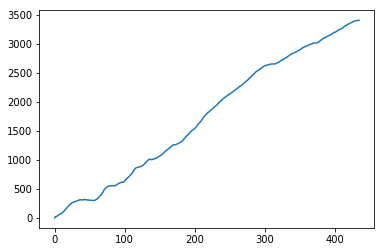

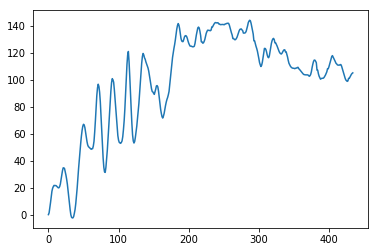

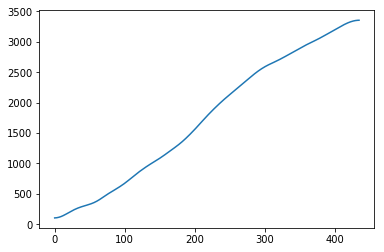

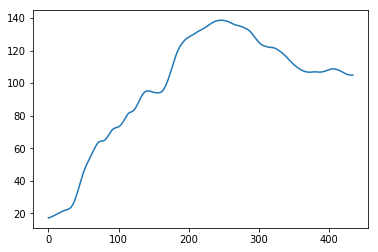

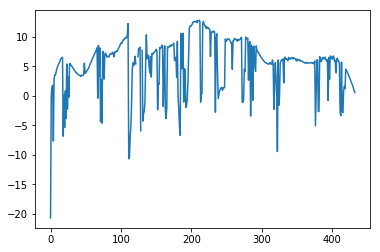

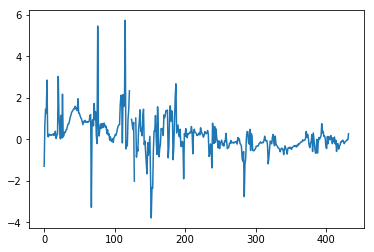

In [41]:
outputMotionStabilization( "../sample videos/shaky_video3.mp4" , 'fv3_MotionStabilization')

# Shaky Video 5

402 401


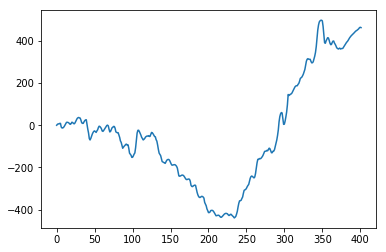

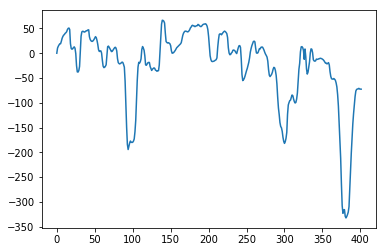

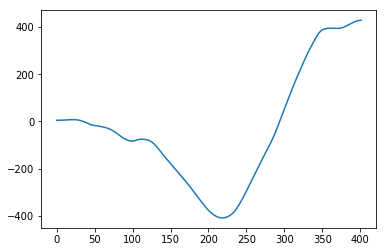

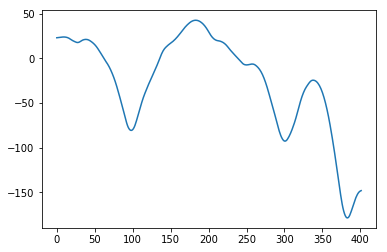

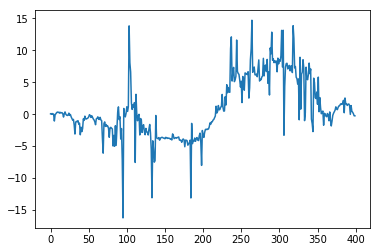

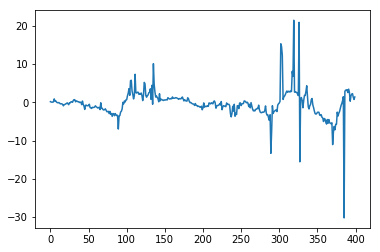

In [42]:
outputMotionStabilization( "../sample videos/shaky_video5.mp4" , 'fv5_MotionStabilization')

# Shaky Video 7

339 338


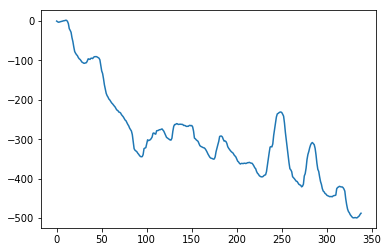

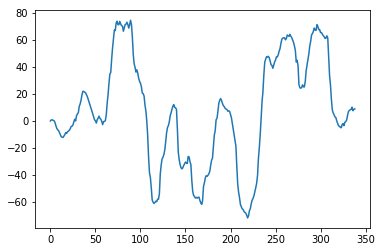

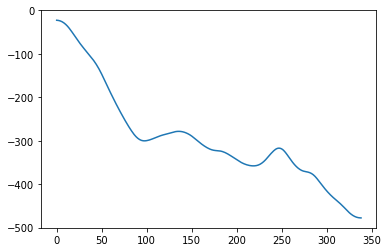

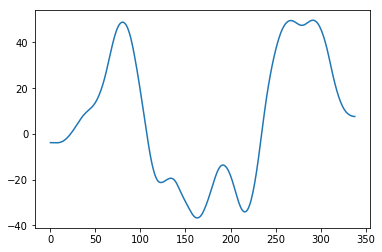

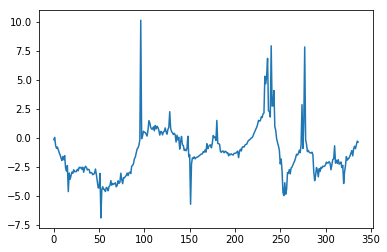

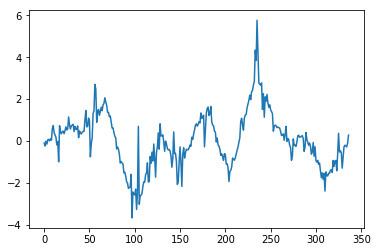

In [43]:
outputMotionStabilization( "../sample videos/shaky_video7.mp4" , 'fv7_MotionStabilization')

# Shaky Video 8

264 263


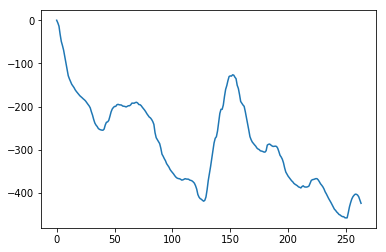

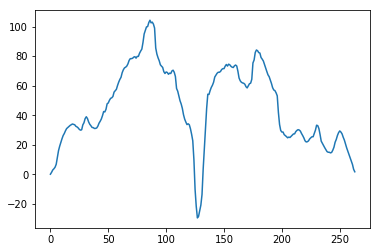

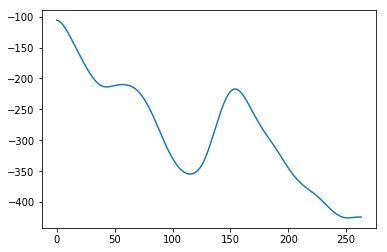

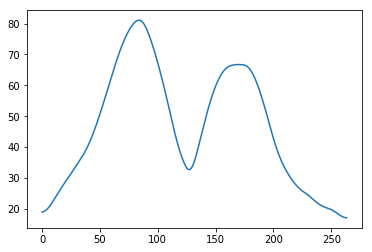

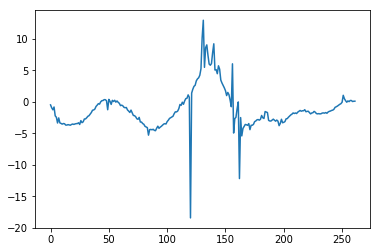

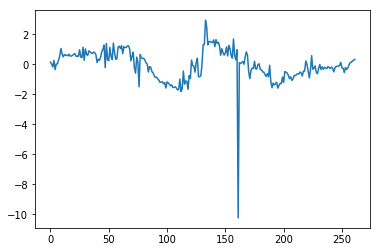

In [44]:
outputMotionStabilization( "../sample videos/shaky_video8.mp4" , 'fv8_MotionStabilization')

# With Neural Network

# shaky video 3

In [0]:
FV3, MV3 = outputMotionStabilizationWithStereo( samplevthree , 'fv3_testfinal')

# shaky video 5

In [0]:
 FV5, MV5 = outputMotionStabilizationWithStereo( samplevfive , 'fv5_testfinal')

# shaky video 7

In [0]:
 FV7, MV7 = outputMotionStabilizationWithStereo( samplevseven , 'fv7_testfinal')

# shaky video 8

In [0]:
 FV8, MV8 = outputMotionStabilizationWithStereo( sampleveight , 'fv8_testfinal')